In [1]:
# Auto-reloading imports on external change. Re-import is necessary though.
%load_ext autoreload
%autoreload 2

from pathlib import Path

import os
import sys
root = Path().resolve().parents[1]
sys.path.append(str(root))

import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from sudoku.image_parser import parse_grid, load_image
from sudoku.plotting import image_from_digits, show_image

def is_image(file: str) -> bool: 
    return (
        file.endswith('.jpg') or 
        file.endswith('.jpeg') or 
        file.endswith('.png')
    )

def is_dat(file: str) -> bool: 
    return (
        file.endswith('.sud') or 
        file.endswith('.dat')
    )

train_directory = 'data/train_cleaned/'
test_directory = 'data/test_cleaned/'

additional_images_train = 'data/sudoku_images/'

def preprocess_data_from_images(directory):
    data = []
    for file in sorted(os.listdir(directory)):
        if is_image(file):
            path = directory + file
            img = load_image(path)         
            digits = parse_grid(img)
            data.append(digits)
    return np.array(data)       

def get_labels_from_images(directory, skiprows=2):
    data = []
    for file in sorted(os.listdir(directory)):
        if is_dat(file):
            path = directory + file
            df = pd.read_csv(
                 path, 
                 sep="\s+", 
                 skiprows=skiprows, header=None)
            data.append(np.array(df).reshape(9, 9))
    return np.array(data)       

x_train = preprocess_data_from_images(train_directory)
x_test = preprocess_data_from_images(test_directory)

y_train = get_labels_from_images(train_directory)
y_test = get_labels_from_images(test_directory)

x_train_add = preprocess_data_from_images(additional_images_train)
y_train_add = get_labels_from_images(additional_images_train, skiprows=0)

x_train = np.vstack((x_train, x_train_add))
y_train = np.vstack((y_train, y_train_add))

In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(119, 81, 28, 28) (119, 9, 9) (15, 81, 28, 28) (15, 9, 9)


In [4]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()

x_mnist_train = x_mnist_train.reshape(x_mnist_train.shape[0], 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], 28, 28, 1)

y_mnist_train = y_mnist_train.reshape(y_mnist_train.shape[0], 1)
y_mnist_test = y_mnist_test.reshape(y_mnist_test.shape[0], 1)

print(x_mnist_train.shape, y_mnist_train.shape, y_mnist_test.shape, y_mnist_test.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 1) (10000, 1)


In [5]:
# show_image(x_mnist_train[5].reshape(28, 28))

In [6]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0]*x_train.shape[1], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0]*x_test.shape[1], 28, 28, 1)

y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1]*y_train.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1]*y_test.shape[2], 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

## Adding Mnist training data to the base training data set
x_train = np.vstack((x_train, x_mnist_train))
y_train = np.vstack((y_train, y_mnist_train))

# x_test = np.vstack((x_test, x_mnist_test))
# y_test = np.vstack((y_test, y_mnist_test))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

(9639, 28, 28, 1) (9639, 1) (1215, 28, 28, 1) (1215, 1)
(69639, 28, 28, 1) (69639, 1) (1215, 28, 28, 1) (1215, 1)
Number of images in x_train 69639
Number of images in x_test 1215


In [7]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# Creating a Sequential Model and adding the layers

input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(256, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(96, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.compile(optimizer="adam", 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
ck = tf.keras.callbacks.ModelCheckpoint(filepath="model_weights_custom.hdf5", verbose=1, save_best_only=True)

model.fit(x=x_train,y=y_train, validation_data=(x_test, y_test), batch_size=128, epochs=100, callbacks=[es, ck])

Train on 69639 samples, validate on 1215 samples
Epoch 1/100
69632/69639 [============================>.] - ETA: 0s - loss: 0.2657 - acc: 0.9234
Epoch 00001: val_loss improved from inf to 0.23691, saving model to model_weights_custom.hdf5
69639/69639 [==============================] - 99s 1ms/sample - loss: 0.2657 - acc: 0.9234 - val_loss: 0.2369 - val_acc: 0.9498
Epoch 2/100
69632/69639 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9736
Epoch 00002: val_loss improved from 0.23691 to 0.19617, saving model to model_weights_custom.hdf5
69639/69639 [==============================] - 99s 1ms/sample - loss: 0.1013 - acc: 0.9736 - val_loss: 0.1962 - val_acc: 0.9630
Epoch 3/100
69632/69639 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9787
Epoch 00003: val_loss improved from 0.19617 to 0.18762, saving model to model_weights_custom.hdf5
69639/69639 [==============================] - 96s 1ms/sample - loss: 0.0828 - acc: 0.9787 - val_loss: 0.1876 - val_a

In [150]:
model.evaluate(x_test, y_test)

1215/1215 [==============================] - 1s 454us/sample - loss: 0.2032 - acc: 0.9597


[0.20319149561624958, 0.9596708]

8


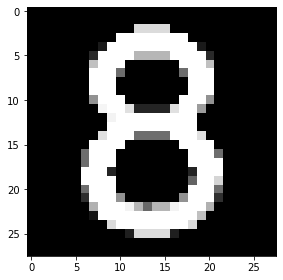

In [9]:
image_index = 25
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())
show_image(x_test[image_index].reshape(28, 28))

8


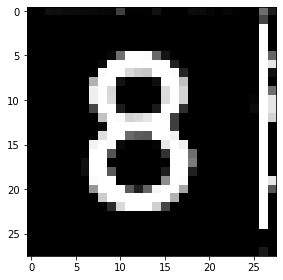

In [151]:
image_index = 25
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())
show_image(x_test[image_index].reshape(28, 28))

In [56]:
pred

array([[4.9504708e-04, 6.7337346e-04, 5.0628227e-01, 2.7107231e-03,
        4.6309200e-03, 2.0965732e-04, 1.5564318e-03, 1.9035868e-03,
        4.8126566e-01, 2.7235667e-04]], dtype=float32)